In [73]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [74]:
def calc_price(theta1, theta2, cost, wtp):
    """compute each insurer's price (assumes interior solution)"""
    p1 = (2*theta1+theta2)/3. + cost
    p2 = (2*theta2+theta1)/3. + cost
    return p1, p2
  
    
def calc_t(theta1, theta2, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(theta1, theta2, cost, wtp)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return t_hat


def calc_profits(theta1,theta2,cost, wtp, mc):
    t= calc_t(theta1, theta2, cost, wtp)
    p1,p2 = calc_price(theta1, theta2, cost, wtp)
    profits1, profits2 = t*(p1-theta1), (1-t)*(p2-theta2)
    mc1,mc2 = mc
    hosp_profit = t*(theta1-mc1) +  (1-t)*(theta2-mc2)
    return hosp_profit, profits1, profits2

    
def outside_simlt(theta1, theta2, cost, wtp,  mc, active=False):
    """outside option in simult case
    assuming listprice high enough"""
    r  = 0 #.25
    t_hat = calc_t(theta1, theta2, cost, wtp)
    mc1,mc2 = mc
    #t_hat = .5
    #print(theta1, theta2,  t_hat)
    if active:
        return (wtp-cost)/2 - mc2 #outside cost is other insurer?
    
    return r*t_hat*(theta2-mc2) + (1-t_hat)*(theta2 -mc2)

#arbitrary outside option...
def nash_in_nash(theta1, theta2, cost, wtp, mc, beta=.5,active=False):
    hosp_profit, profits1, profits2 = calc_profits(theta1, theta2,  cost,  wtp, mc)
    obj = -1*(np.log(max(hosp_profit-outside_simlt(theta1, theta2,cost, wtp , mc, active=active),1e-4))*(1-beta) 
              + np.log(profits1)*beta)
    return obj


COST = 5
WTP = 25
MC = np.array([0,0])

print(nash_in_nash(COST,COST, COST, WTP, MC))

-0.9162907318741551


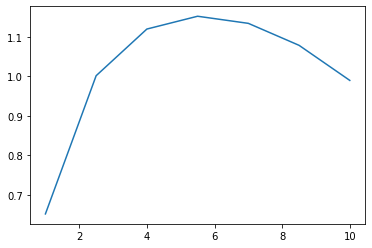

In [75]:
COST = 5
WTP = 25
MC = np.array([0,0])

plt.plot([i for i in np.linspace(1,2*COST,num=7)], 
         [-1*nash_in_nash(i, 7.5, COST,WTP,MC) for i in np.linspace(1,2*COST,num=7)])

In [76]:
def bargain_helper(theta1, theta2, cost, wtp, mc, beta=.5,active=False):
    """solve each firm 1s optimization holding theta 2 fixed"""
    result = minimize(nash_in_nash, theta1, args=(theta2,cost, wtp, mc, beta, active),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

COST = 5
WTP  = 25
MC = np.array([0,0])

print(bargain_helper(7.5,7.5, COST,WTP,MC,beta=.5,active=True))

[-4.75368975e+29]


In [77]:
def simult_bargain(theta1, theta2, cost, wtp, mc, betas=[.5,.5],active=False):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  theta1

    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta1 = bargain_helper(theta1, theta2, cost, wtp, mc, beta=betas[0] ,active=active)
        theta2 = bargain_helper(theta2, theta1, cost, wtp, mc[::-1], beta=betas[1],active=active)
        
        #update loop variables
        diff = np.abs(np.max(theta1 - theta2))
        maxiter = maxiter-1
        
    return theta1, theta2

COST = 5
WTP  = 25
MC = np.array([4,4])
print(simult_bargain(11.25,11.25,COST,WTP,MC,active=False))
print(simult_bargain(11.25,11.25,COST,WTP,MC,active=True))

(array([8.99999815]), array([8.99999621]))
(array([13.74998685]), array([13.75003069]))


In [97]:
#generate a bunch of runs with passive and compute costs

def compute_cov(active,nobs=1000):
    mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    for i in range(nobs):
        phi = simult_bargain(11.25,11.25,COST,WTP,mcs[:,i],active=active) 
        phis.append(np.array(phi).flatten())

    phis = np.array(phis)
    return np.cov(phis,rowvar=False)

print(compute_cov(active=True))
print(compute_cov(active=False))

[[ 0.17721704 -0.1759979 ]
 [-0.1759979   0.17552642]]
[[0.22016708 0.10790257]
 [0.10790257 0.2305333 ]]
